In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from IPython.display import Audio, display
import sounddevice as sd


## Adquirindo áudio original

#### Parâmetros

execute este trecho de código sempre!

In [2]:
# %% Parâmetros
duracao = 8  # duração em segundos
fs = 44100  # taxa de amostragem padrão
nBits = 16  # bits por amostra (usado implicitamente pelo sounddevice para tipo de dado)
nCanais = 1  # MONO

#### Adquirindo por gravação

In [37]:
# %% Gravação do áudio mono
print('Iniciando gravação mono... Fale agora.')
x_mono = sd.rec(int(duracao * fs), samplerate=fs, channels=nCanais, dtype='float64')
sd.wait()  # Espera a gravação terminar
print('Gravação encerrada.')

Iniciando gravação mono... Fale agora.
Gravação encerrada.


In [38]:
# Garante que 'x_mono' seja um array 1D caso sd.rec retorne (N,1)
if x_mono.ndim > 1:
    x_mono = x_mono.flatten()

In [39]:
# %% Salva o áudio original (sem ruído)
output_filename_original = '../audios/audio_original2_gravado.wav'
write(output_filename_original, fs, (x_mono * (2**15 - 1)).astype(np.int16))
print(f'Arquivo do áudio original salvo: {output_filename_original}')

Arquivo do áudio original salvo: ../audios/audio_original2_gravado.wav


#### Adquirindo via áudio preexistente

In [3]:
# Se quiser carregar um audio preexistente
from scipy.io.wavfile import read
import os

output_filename_original = '../audios/audio_original_gravado.wav'

if os.path.exists(output_filename_original):
    # print(f'Arquivo "{output_filename_original}" encontrado. Carregando áudio...') # Comentado para ser mais conciso
    samplerate_read, x_mono = read(output_filename_original)
    if x_mono.dtype == np.int16:
        x_mono = x_mono.astype(np.float64) / (2**15)
    elif x_mono.dtype == np.int32:
        x_mono = x_mono.astype(np.float64) / (2**31)
    if x_mono.ndim > 1:
        if x_mono.shape[1] > 1:
            x_mono = x_mono[:, 0]
        x_mono = x_mono.flatten()
    # print('Áudio carregado com sucesso.') # Comentado para ser mais conciso
else:
    print(f'Erro: Arquivo "{output_filename_original}" não encontrado. Por favor, grave o áudio primeiro.')
    x_mono = np.array([]) # Define x_mono como array vazio para evitar NameError em células futuras

#### Gráfico áudio original (tempo)

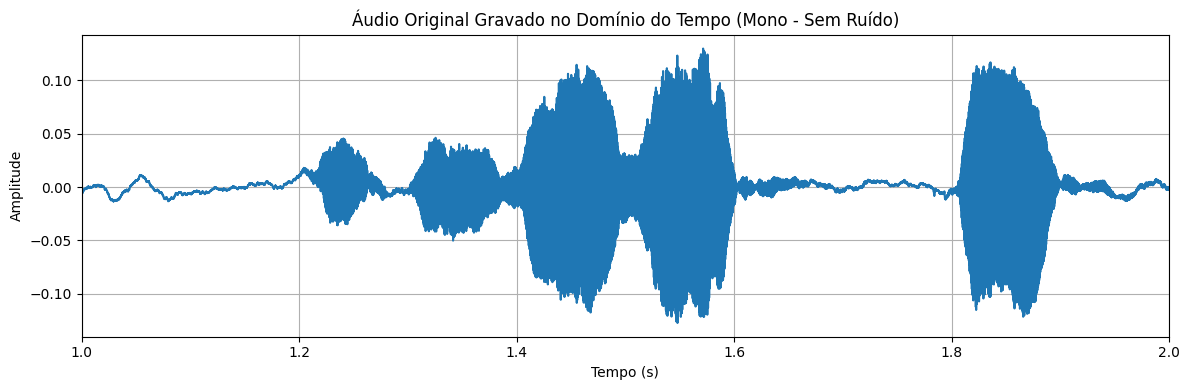

In [4]:
# Plot do sinal original (sem ruído) no domínio do tempo
plt.figure(figsize=(12, 4))
plt.plot(np.arange(x_mono.shape[0]) / fs, x_mono)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Áudio Original Gravado no Domínio do Tempo (Mono - Sem Ruído)')
plt.xlim([1, 2]) # Zoom nos primeiros 50 ms para detalhes
plt.grid(True)
plt.tight_layout()


plt.savefig('../graficos/audio_original_tempo.png')


plt.show()

#### Gráfico áudio original (frequência)

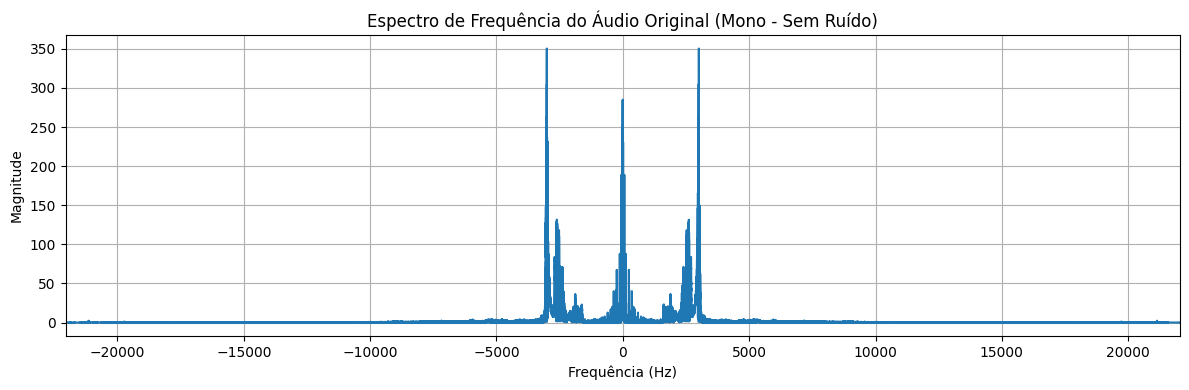

In [6]:
# Plot do sinal original (sem ruído) no domínio da frequência
N_original = x_mono.shape[0]
f_original = np.fft.fftfreq(N_original, 1/fs)
f_original_shifted = np.fft.fftshift(f_original)
X_original = np.fft.fft(x_mono)
X_original_shifted = np.fft.fftshift(X_original)


plt.figure(figsize=(12, 4))
plt.plot(f_original_shifted, np.abs(X_original_shifted))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Original (Mono - Sem Ruído)')
plt.xlim([-fs / 2, fs / 2])
plt.grid(True)
plt.tight_layout()

plt.savefig('../graficos/audio_original_frequencia.png')

plt.show()


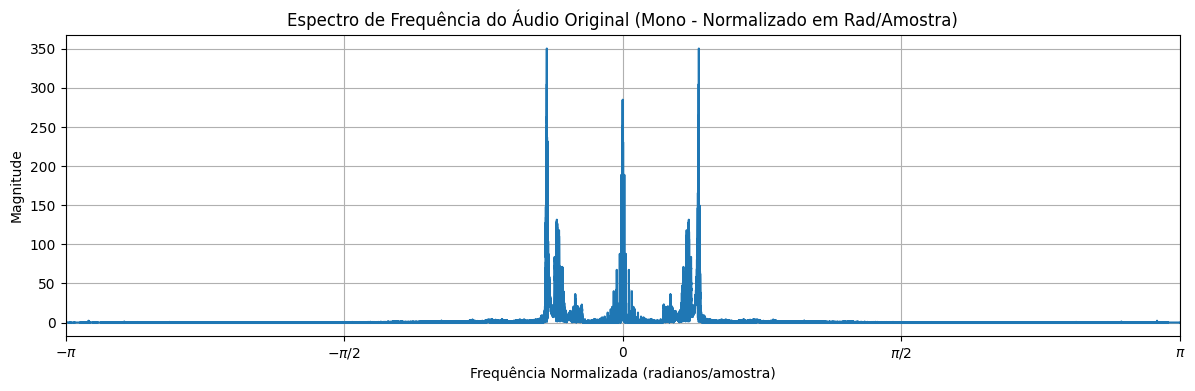

In [7]:
f_original_rad_shifted = f_original_shifted * (2 * np.pi / fs)


plt.figure(figsize=(12, 4))
plt.plot(f_original_rad_shifted, np.abs(X_original_shifted))
plt.xlabel('Frequência Normalizada (radianos/amostra)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Original (Mono - Normalizado em Rad/Amostra)')
plt.xlim([-np.pi, np.pi]) # Limita o eixo X de -pi a pi
plt.grid(True)
plt.tight_layout()
# Configura os rótulos do eixo X para mostrar os valores em termos de pi.
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])

plt.savefig('../graficos/audio_original_frequencia_rad_amostra.png')


plt.show()

#### Reproduzir áudio original

In [8]:
# Para reproduzir o áudio original (sem ruído) no Jupyter local
output_filename_original = '../audios/audio_original_gravado.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio original (sem ruído):')
display(Audio(output_filename_original))


Reproduzindo o áudio original (sem ruído):


## Contaminando com ruído

#### Gerando ruído

In [9]:
# %% Geração do sinal de ruído (mesmo tamanho e um canal)
t = np.arange(0, duracao, 1/fs)
# Frequências e amplitudes do ruído
f1 = 5900
f2 = 6200
a1 = 0.01
a2 = 0.01

# Sinal de ruído mono
r = a1 * np.cos(2 * np.pi * f1 * t) + a2 * np.cos(2 * np.pi * f2 * t)
#r = r / np.max(np.abs(r))  # normaliza

# Garante que 'r' tenha a mesma forma para a soma
if r.ndim > 1:
    r = r.flatten()

#### Somando sinal + ruído

In [10]:
# %% Soma do áudio gravado com o ruído
# Para somar, os dois sinais precisam ter o mesmo comprimento
len_min = min(x_mono.shape[0], r.shape[0])
x_mono_cropped = x_mono[:len_min] # Usa a versão cortada para soma
r_cropped = r[:len_min]
sinal_resultante = x_mono_cropped + r_cropped

# Normalizar para evitar clipping
sinal_resultante = sinal_resultante / np.max(np.abs(sinal_resultante))

In [11]:
# %% Salva o áudio com ruído
output_filename_ruido = '../audios/audio_com_ruido.wav'
# A função write espera os dados em um formato inteiro (por exemplo, int16 para 16 bits).
# Como nosso sinal_resultante está normalizado entre -1 e 1 (float),
# multiplicamos ele pelo valor máximo de um int16 (2**15 - 1 = 32767)
# e depois convertemos para o tipo np.int16.
write(output_filename_ruido, fs, (sinal_resultante * (2**15 - 1)).astype(np.int16))
print(f'Arquivo do áudio com ruído salvo: {output_filename_ruido}')

Arquivo do áudio com ruído salvo: ../audios/audio_com_ruido.wav


#### Gráfico sinal contaminado (tempo)

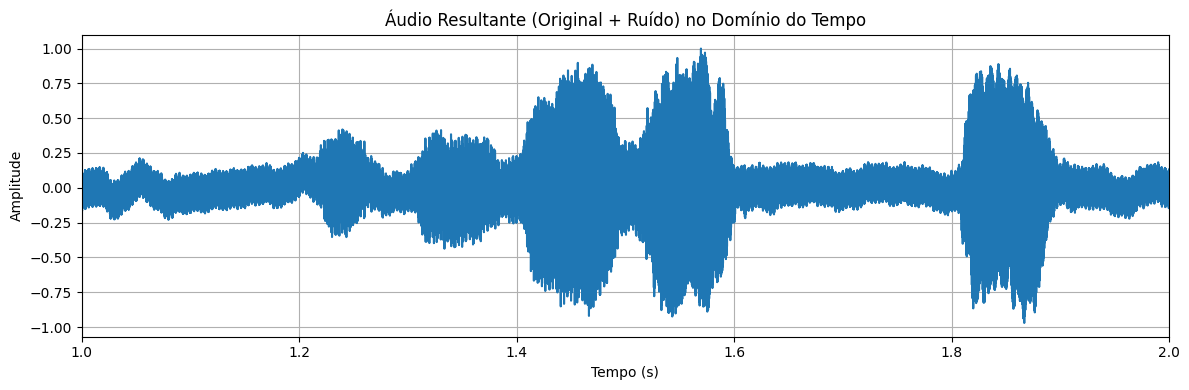

In [12]:
# Plot do sinal resultante - domínio do tempo
plt.figure(figsize=(12, 4)) # Cria a figura
plt.plot(np.arange(sinal_resultante.shape[0]) / fs, sinal_resultante) # ADICIONA O GRÁFICO
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Áudio Resultante (Original + Ruído) no Domínio do Tempo')
plt.xlim([1, 2])
plt.grid(True)
plt.tight_layout()

plt.savefig('../graficos/audio_contaminado_tempo.png')

plt.show() 

#### Gráfico sinal contaminado (frequência)

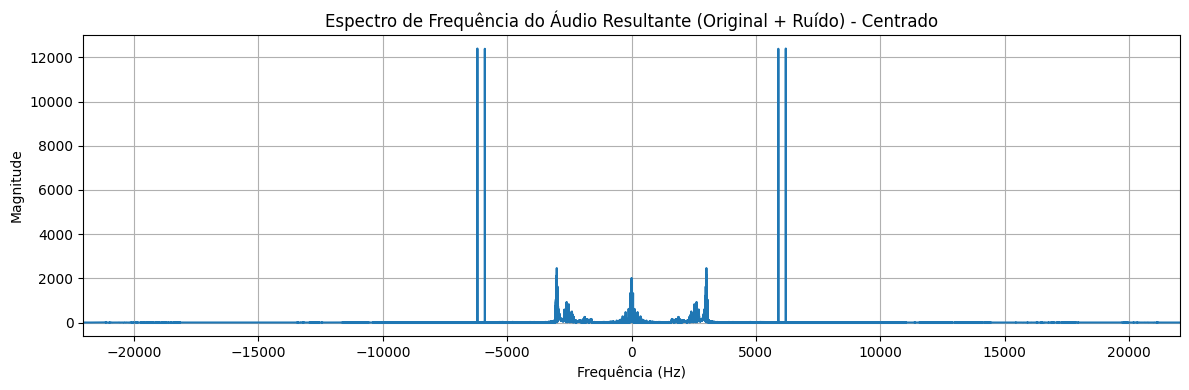

In [14]:
# %% Plot do sinal resultante - domínio da frequência (em Hertz - Completo e Centrado)
# Calcula o número de amostras do sinal resultante
N_resultante = sinal_resultante.shape[0]

# Realiza a Transformada Rápida de Fourier (FFT)
R_resultante = np.fft.fft(sinal_resultante)

# Reorganiza o espectro para ter a frequência zero no centro
R_resultante_shifted = np.fft.fftshift(R_resultante)

# Calcula as frequências correspondentes para o espectro
# np.fft.fftfreq retorna as frequências de amostragem na ordem padrão.
# Para corresponder ao fftshift, também precisamos "shiftar" as frequências.
f_resultante = np.fft.fftfreq(N_resultante, 1/fs)
f_resultante_shifted = np.fft.fftshift(f_resultante)

plt.figure(figsize=(12, 4))
# Plota o espectro completo (positivo e negativo), com 0 Hz no centro
plt.plot(f_resultante_shifted, np.abs(R_resultante_shifted))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Resultante (Original + Ruído) - Centrado')
plt.xlim([-fs / 2, fs / 2]) # Limita o eixo X de -Nyquist a +Nyquist
plt.grid(True)
plt.tight_layout()

plt.savefig('../graficos/audio_contaminado_frequencia.png')

plt.show()

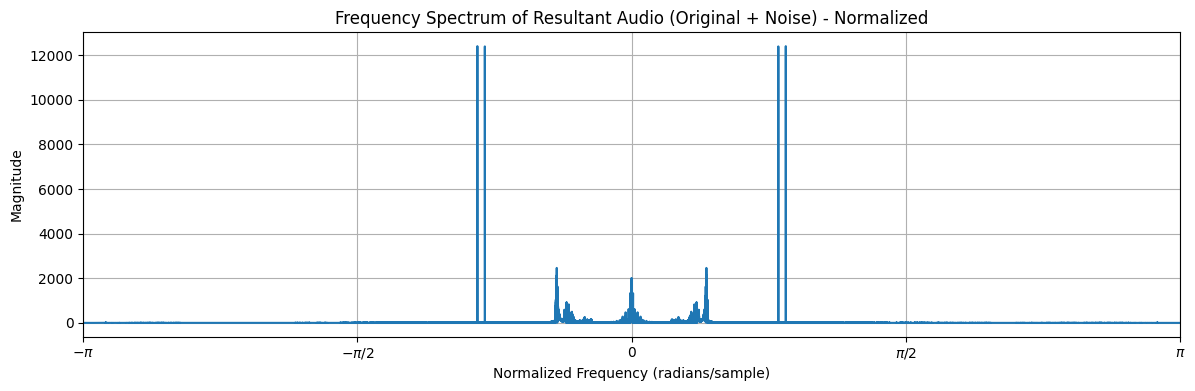

In [15]:
f_resultante_rad_shifted = f_resultante_shifted * (2 * np.pi / fs)


plt.figure(figsize=(12, 4))
plt.plot(f_resultante_rad_shifted, np.abs(R_resultante_shifted))
plt.xlabel('Normalized Frequency (radians/sample)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Resultant Audio (Original + Noise) - Normalized')
plt.xlim([-np.pi, np.pi]) # Set X-axis limits from -pi to pi
plt.grid(True)
plt.tight_layout()
# Set X-axis ticks to show values in terms of pi.
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])


plt.savefig('../graficos/audio_contaminado_frequencia_rad_amostra.png')

plt.show()

#### Reproduzir áudio contaminado

In [16]:
# Para reproduzir o áudio modificado (com ruído) no Jupyter local
output_filename_original = '../audios/audio_com_ruido.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio modificado (com ruído):')
display(Audio(output_filename_original))


Reproduzindo o áudio modificado (com ruído):


## Filtro Rejeita faixa

#### Parâmetros do filtro

In [17]:
# %% Parâmetros
M = 84
fs = 44100
Ts = 1 / fs

f1 = 5000
f2 = 7000
omega_a = (2 * np.pi * f1) / fs
omega_b = (2 * np.pi * f2) / fs

#### Resposta ao impulso do filtro

In [19]:
n = np.arange(M + 1)
nc = M / 2

# %% Resposta impulsional ideal do filtro passa-faixa
hd_bp = np.zeros(M + 1)

for i in range(M + 1):
    n_diff = i - nc
    if n_diff == 0:
        hd_bp[i] = (omega_b - omega_a) / np.pi
    else:
        hd_bp[i] = (np.sin(omega_b * n_diff) - np.sin(omega_a * n_diff)) / (np.pi * n_diff) # aqui eu tinha errado na parte 1, tinha usado + no lugar de -

# %% Delta (impulso deslocado para n = nc)
delta = np.zeros(M + 1)
delta[int(nc)] = 1

# %% Filtro rejeita-faixa = delta - passa-faixa
hd_notch = delta - hd_bp

# %% Janela de Hamming
w = 0.54 - 0.46 * np.cos(2 * np.pi * n / M)
h = hd_notch * w

#### Gráfico da resposta do filtro (tempo)

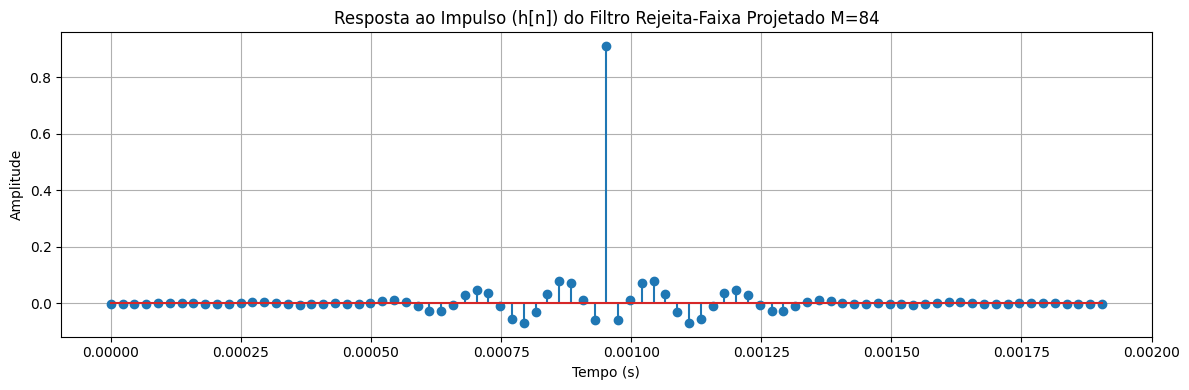

In [21]:
plt.figure(figsize=(12, 4))
plt.stem(n * Ts, h)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title(f'Resposta ao Impulso (h[n]) do Filtro Rejeita-Faixa Projetado M={M}')
plt.grid(True)
plt.tight_layout()

plt.savefig('../graficos/filtro_tempo.png')

plt.show()

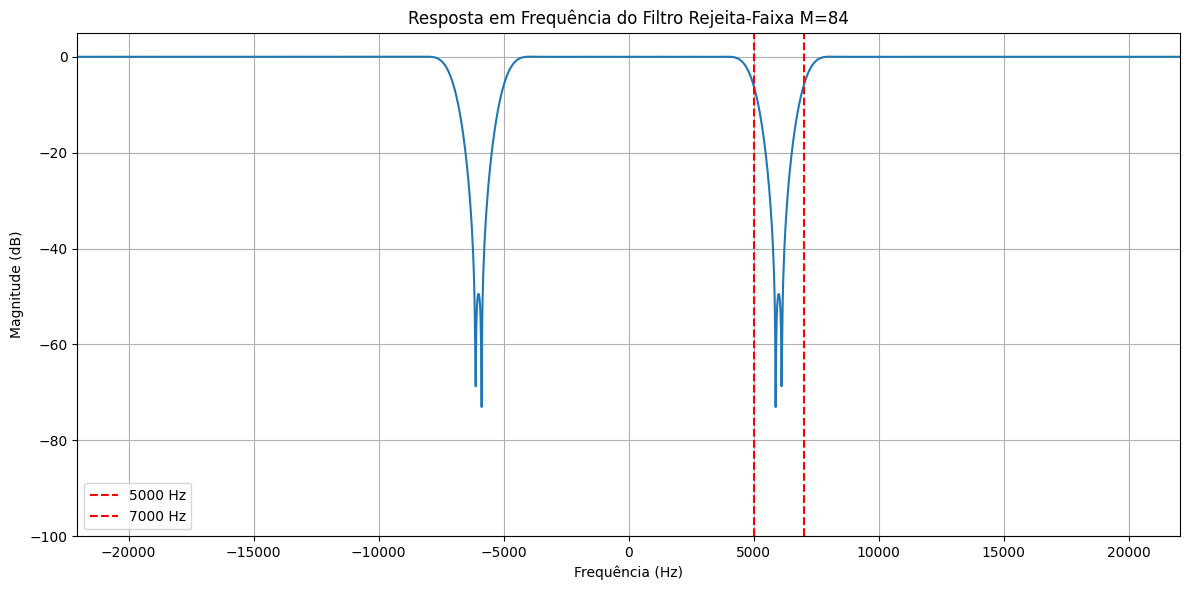

In [22]:
# %% Espectro
H = np.fft.fft(h, 2048)  # FFT maior para mais resolução
f = np.fft.fftfreq(len(H), Ts)
H_shifted = np.fft.fftshift(H)
f_shifted = np.fft.fftshift(f)

plt.figure(figsize=(12, 6))
plt.plot(f_shifted, 20 * np.log10(np.abs(H_shifted) + 1e-10))
plt.axvline(f1, color='r', linestyle='--', label=f'{f1} Hz')
plt.axvline(f2, color='r', linestyle='--', label=f'{f2} Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title(f'Resposta em Frequência do Filtro Rejeita-Faixa M={M}')
plt.grid(True)
plt.legend()
plt.xlim([-fs/2, fs/2])
plt.ylim([-100, 5])
plt.tight_layout()

plt.savefig('../graficos/filtro_frequencia.png')

plt.show()


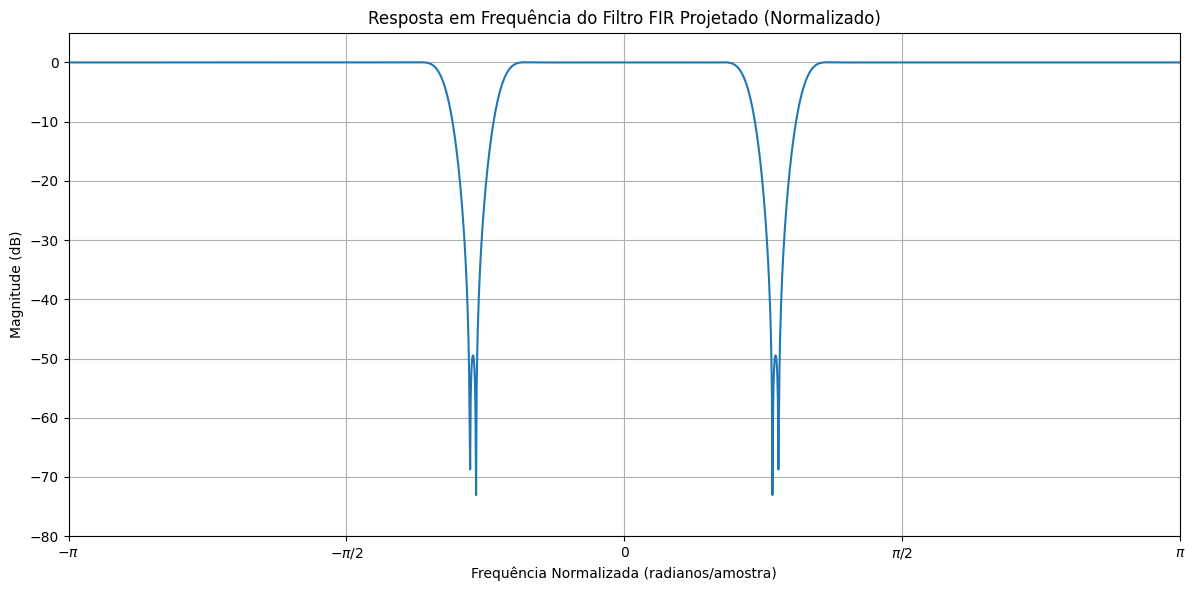

In [24]:

# %% Plotagem da Resposta em Frequência do Filtro (Normalizado em Radianos/Amostra)

# Normaliza as frequências (já shiftadas em Hz) para radianos/amostra.
# A conversão é: frequência_Hz * (2 * pi / fs)
f_filter_rad_shifted = f_shifted * (2 * np.pi / fs)

plt.figure(figsize=(12, 6))
# Plot da magnitude em dB.
# H_shifted já está centrado, assim como f_filter_rad_shifted.
plt.plot(f_filter_rad_shifted, 20 * np.log10(np.abs(H_shifted) + 1e-10))
plt.xlabel('Frequência Normalizada (radianos/amostra)')
plt.ylabel('Magnitude (dB)')
plt.title('Resposta em Frequência do Filtro FIR Projetado (Normalizado)')
plt.grid(True)
plt.xlim([-np.pi, np.pi]) # Limita o eixo X de -pi a pi
plt.ylim([-80, 5]) # Limites típicos para visualização de filtros em dB
plt.tight_layout()
# Configura os rótulos do eixo X para mostrar os valores em termos de pi.
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])

plt.savefig('../graficos/filtro_frequencia_rad_amostra.png')

plt.show()

## Aplicando filtro ao sinal contaminado

#### Aplicando o filtro

In [29]:
from scipy import signal

# %% Aplicação do Filtro
# 'h' são os coeficientes do numerador (FIR), e '[1]' é o denominador (para FIR é sempre 1)
sinal_filtrado = signal.lfilter(h, [1], sinal_resultante)

# %% Normalizar o sinal filtrado para evitar clipping
# A filtragem pode alterar a amplitude do sinal, então é bom normalizar novamente.
sinal_filtrado = sinal_filtrado / np.max(np.abs(sinal_filtrado))

# %% Salvar o áudio filtrado
output_filename_filtrado = '../audios/audio_filtrado.wav'
write(output_filename_filtrado, fs, (sinal_filtrado * (2**15 - 1)).astype(np.int16))
print(f'Arquivo do áudio filtrado salvo: {output_filename_filtrado}')

Arquivo do áudio filtrado salvo: ../audios/audio_filtrado.wav


#### Gráfico áudio filtrado (tempo)

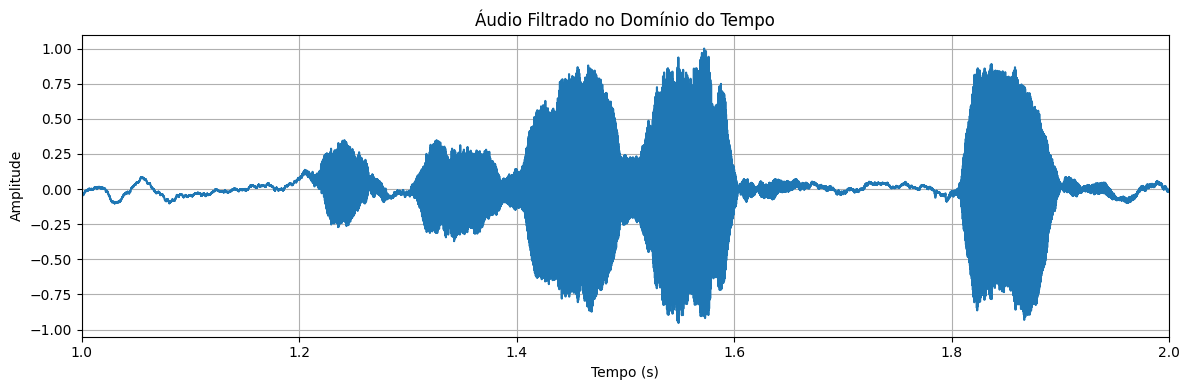

In [34]:
# %% Plotar o sinal filtrado no domínio do tempo (para visualização)
plt.figure(figsize=(12, 4))
plt.plot(np.arange(sinal_filtrado.shape[0]) / fs, sinal_filtrado)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Áudio Filtrado no Domínio do Tempo')
plt.xlim([1, 2]) # Zoom para ver detalhes
plt.grid(True)
plt.tight_layout()

plt.savefig('../graficos/audio_filtrado_tempo.png')

plt.show()


#### Gráfico do áudio filtrado (frequência)

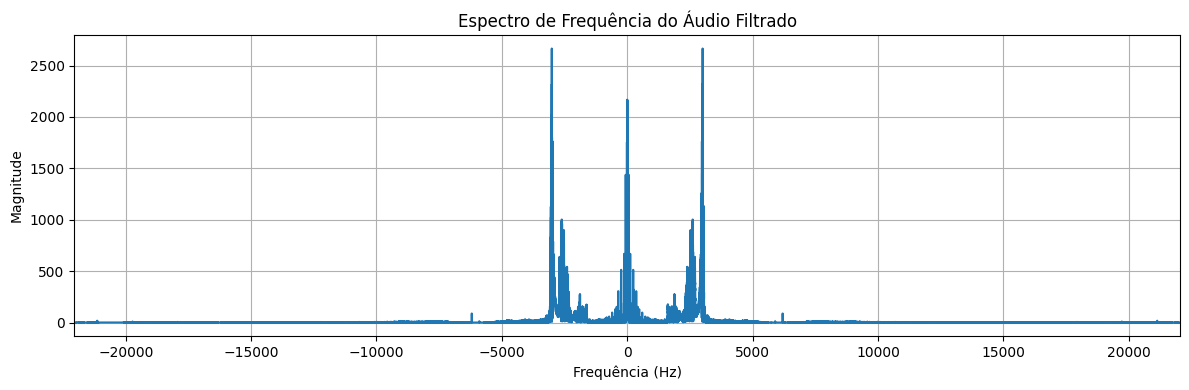

In [38]:
N_filtrado = sinal_filtrado.shape[0]
f_filtrado = np.fft.fftfreq(N_filtrado, 1/fs)
R_filtrado = np.fft.fft(sinal_filtrado)

f_filtrado_shifted = np.fft.fftshift(f_filtrado)
R_filtrado_shifted = np.fft.fftshift(R_filtrado)


plt.figure(figsize=(12, 4))
plt.plot(f_filtrado_shifted, np.abs(R_filtrado_shifted))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Filtrado')
plt.xlim([-fs / 2, fs / 2])
plt.grid(True)
plt.tight_layout()

plt.savefig('../graficos/audio_filtrado_frequencia.png')


plt.show()

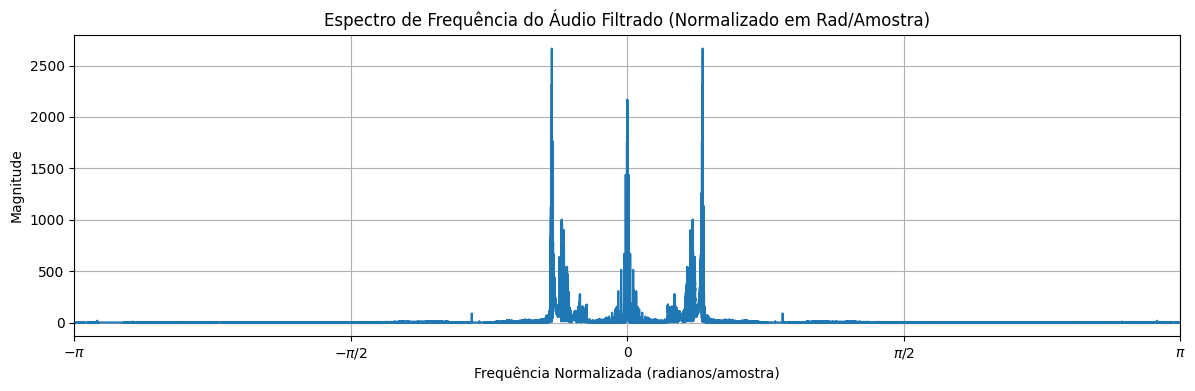

In [40]:

f_filtrado_rad_shifted = f_filtrado_shifted * (2 * np.pi / fs)
plt.figure(figsize=(12, 4))

plt.plot(f_filtrado_rad_shifted, np.abs(R_filtrado_shifted))


plt.xlabel('Frequência Normalizada (radianos/amostra)')

plt.ylabel('Magnitude')
plt.title('Espectro de Frequência do Áudio Filtrado (Normalizado em Rad/Amostra)')
plt.xlim([-np.pi, np.pi])
plt.grid(True)
plt.tight_layout()

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])


plt.savefig('../graficos/audio_filtrado_frequencia_rad_amostra.png')


plt.show()

#### Reproduzir áudio filtrado

In [41]:
# Para reproduzir o áudio filtrado no Jupyter local
output_filename_filtrado = '../audios/audio_filtrado.wav' # Caminho para o arquivo salvo
print('\nReproduzindo o áudio filtrado:')
display(Audio(output_filename_filtrado))


Reproduzindo o áudio filtrado:
